In [4]:
# SECTION 1: INSTALL PACKAGES & AUTHENTICATE GOOGLE EARTH ENGINE

# Install Required Packages
!pip install earthengine-api geemap pandas numpy matplotlib folium --quiet

# Import Libraries
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from datetime import datetime

print("All packages installed successfully")

# Authenticate Google Earth Engine
ee.Authenticate()

# Initialize Earth Engine with your project
ee.Initialize(project='neon-hyperspectral-ml-project')

print("Earth Engine authenticated successfully")

# Load Landsat Collection
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
print("Landsat Collection 2 Level-2 loaded")

# Define Study Sites
# Site 1: Harvard Forest, Massachusetts (NEON Site: HARV)
site_1 = {
    'name': 'Harvard Forest',
    'lat': 42.5370,
    'lon': -72.1850,
    'radius': 5000,
    'ecosystem': 'Temperate Deciduous Forest'
}

# Site 2: Black Rock Forest, New York
site_2 = {
    'name': 'Black Rock Forest',
    'lat': 41.40806,
    'lon': -74.02167,
    'radius': 5000,
    'ecosystem': 'Temperate Deciduous Forest'
}

print("\n" + "="*60)
print("STUDY SITES FOR COMPARISON")
print("="*60)
print(f"\n Site 1: {site_1['name']}")
print(f"   Coordinates: {site_1['lat']:.4f}°N, {site_1['lon']:.4f}°W")
print(f"   Ecosystem: {site_1['ecosystem']}")
print(f"   Analysis Radius: {site_1['radius']} meters")

print(f"\n Site 2: {site_2['name']}")
print(f"   Coordinates: {site_2['lat']:.4f}°N, {site_2['lon']:.4f}°W")
print(f"   Ecosystem: {site_2['ecosystem']}")
print(f"   Analysis Radius: {site_2['radius']} meters")
print("="*60)

# Set Analysis Parameters
start_date = '2013-02-01'
end_date = '2013-12-31'

# Cloud cover threshold
cloud_threshold = 20

# Create Interactive Map for Visualization
# Center map between the two sites
center_lat = (site_1['lat'] + site_2['lat']) / 2
center_lon = (site_1['lon'] + site_2['lon']) / 2

comparison_map = folium.Map(location=[center_lat, center_lon], zoom_start=7, tiles='OpenStreetMap')

# Add markers for both sites
folium.Marker(
    location=[site_1['lat'], site_1['lon']],
    popup=f"<b>{site_1['name']}</b><br>{site_1['ecosystem']}",
    icon=folium.Icon(color='green', icon='tree-conifer', prefix='fa')
).add_to(comparison_map)

folium.Marker(
    location=[site_2['lat'], site_2['lon']],
    popup=f"<b>{site_2['name']}</b><br>{site_2['ecosystem']}",
    icon=folium.Icon(color='blue', icon='tree-conifer', prefix='fa')
).add_to(comparison_map)

# Add circle buffers for analysis radius
folium.Circle(
    location=[site_1['lat'], site_1['lon']],
    radius=site_1['radius'],
    color='green',
    fill=True,
    fill_opacity=0.2,
    popup=f"{site_1['name']}: {site_1['radius']}m radius"
).add_to(comparison_map)

folium.Circle(
    location=[site_2['lat'], site_2['lon']],
    radius=site_2['radius'],
    color='blue',
    fill=True,
    fill_opacity=0.2,
    popup=f"{site_2['name']}: {site_2['radius']}m radius"
).add_to(comparison_map)

# Add layer control
folium.LayerControl().add_to(comparison_map)

# Display map
print("\nInteractive map displayed below:")
display(comparison_map)

All packages installed successfully
Earth Engine authenticated successfully
Landsat Collection 2 Level-2 loaded

STUDY SITES FOR COMPARISON

 Site 1: Harvard Forest
   Coordinates: 42.5370°N, -72.1850°W
   Ecosystem: Temperate Deciduous Forest
   Analysis Radius: 5000 meters

 Site 2: Black Rock Forest
   Coordinates: 41.4081°N, -74.0217°W
   Ecosystem: Temperate Deciduous Forest
   Analysis Radius: 5000 meters

Interactive map displayed below:


In [5]:
# SECTION 2: EXTRACT LANDSAT NDVI & EVI FOR HARVARD & BLACK ROCK
# Define Landsat Band Mapping (Collection 2 Level-2)
BANDS = ['SR_B3', 'SR_B4', 'SR_B5']
print(f"Using Landsat 8 bands: {BANDS}")

# Function to Calculate NDVI and EVI
def calculate_indices(image):
    """Calculate NDVI and EVI from Landsat 8 Surface Reflectance bands"""
    # Extract bands
    green = image.select('SR_B3')
    red = image.select('SR_B4')
    nir = image.select('SR_B5')

    # NDVI: (NIR - Red) / (NIR + Red)
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

    # EVI: 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Green + 1)
    evi = green.multiply(-7.5).add(red.multiply(6)).add(nir).add(1)
    evi = nir.subtract(red).divide(evi).multiply(2.5).rename('EVI')

    # Add indices to image
    return image.addBands(ndvi).addBands(evi)

# Function to Get Best Image for a Site
def get_best_image(site, landsat_collection, start_date, end_date, cloud_threshold):
    """
    Filter Landsat collection and return the single best image
    for a given site and date range.
    """
    # Create geometry for the site (circle buffer)
    point = ee.Geometry.Point([site['lon'], site['lat']])
    geometry = point.buffer(site['radius'])

    # Filter collection
    filtered = (landsat_collection
                .filterDate(start_date, end_date)
                .filterBounds(geometry)
                .filter(ee.Filter.lt('CLOUD_COVER', cloud_threshold))
                .select(BANDS)
                .map(calculate_indices)
                .sort('CLOUD_COVER')
                )

    # Get the first image
    best_image = filtered.first()

    return best_image, geometry

# Extract Best Image for Each Site
print(f"\nSearching for best Landsat image for {site_1['name']}...")
image_1, geom_1 = get_best_image(site_1, landsat, start_date, end_date, cloud_threshold)

print(f"Searching for best Landsat image for {site_2['name']}...")
image_2, geom_2 = get_best_image(site_2, landsat, start_date, end_date, cloud_threshold)

# Check if images were found
if image_1 is None or image_2 is None:
    print("Could not find suitable cloud-free images for one or both sites.")
    print("Try expanding the date range or increasing cloud_threshold.")
    raise StopIteration

# Get image metadata for reporting
def get_image_info(image, site_name):
    """Extract key metadata from an Earth Engine image"""
    info = image.getInfo()
    props = info['properties']
    return {
        'site': site_name,
        'image_id': props.get('LANDSAT_PRODUCT_ID', 'N/A'),
        'date': props.get('DATE_ACQUIRED', 'N/A'),
        'cloud_cover': props.get('CLOUD_COVER', 'N/A'),
        'path': props.get('WRS_PATH', 'N/A'),
        'row': props.get('WRS_ROW', 'N/A')
    }

info_1 = get_image_info(image_1, site_1['name'])
info_2 = get_image_info(image_2, site_2['name'])

print("\n" + "-"*60)
print("SELECTED LANDSAT IMAGES")
print("-"*60)
print(f"\n{info_1['site']}:")
print(f"   Image ID: {info_1['image_id']}")
print(f"   Acquisition Date: {info_1['date']}")
print(f"   Cloud Cover: {info_1['cloud_cover']:.1f}%")
print(f"   WRS Path/Row: {info_1['path']}/{info_1['row']}")

print(f"\n{info_2['site']}:")
print(f"   Image ID: {info_2['image_id']}")
print(f"   Acquisition Date: {info_2['date']}")
print(f"   Cloud Cover: {info_2['cloud_cover']:.1f}%")
print(f"   WRS Path/Row: {info_2['path']}/{info_2['row']}")
print("-"*60)

# Extract Mean NDVI & EVI Within Analysis Radius
print(f"\nExtracting mean vegetation indices within {site_1['radius']}m radius...")

# Function to extract mean index values
def extract_mean_indices(image, geometry, site_name):
    """Calculate mean NDVI and EVI within a geometry"""
    stats = image.select(['NDVI', 'EVI']).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=30,
        maxPixels=1e9,
        bestEffort=True
    )
    return stats.getInfo()

# Extract for both sites
stats_1 = extract_mean_indices(image_1, geom_1, site_1['name'])
stats_2 = extract_mean_indices(image_2, geom_2, site_2['name'])

print(f"\nMean vegetation indices extracted:")
print(f"\n{site_1['name']}:")
print(f"   NDVI: {stats_1.get('NDVI', 'N/A'):.4f}" if stats_1.get('NDVI') else "   NDVI: N/A")
print(f"   EVI:  {stats_1.get('EVI', 'N/A'):.4f}" if stats_1.get('EVI') else "   EVI: N/A")

print(f"\n{site_2['name']}:")
print(f"   NDVI: {stats_2.get('NDVI', 'N/A'):.4f}" if stats_2.get('NDVI') else "   NDVI: N/A")
print(f"   EVI:  {stats_2.get('EVI', 'N/A'):.4f}" if stats_2.get('EVI') else "   EVI: N/A")

# Store Results in DataFrame for Later Analysis
comparison_data = pd.DataFrame([
    {
        'Site': site_1['name'],
        'Date': info_1['date'],
        'Cloud_Cover': info_1['cloud_cover'],
        'NDVI_Mean': stats_1.get('NDVI'),
        'EVI_Mean': stats_1.get('EVI'),
        'Ecosystem': site_1['ecosystem']
    },
    {
        'Site': site_2['name'],
        'Date': info_2['date'],
        'Cloud_Cover': info_2['cloud_cover'],
        'NDVI_Mean': stats_2.get('NDVI'),
        'EVI_Mean': stats_2.get('EVI'),
        'Ecosystem': site_2['ecosystem']
    }
])

print("\nComparison DataFrame created:")
display(comparison_data)

# Save to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

comparison_data.to_csv('/content/drive/MyDrive/NEON Hyperspectral ML Project/site_comparison_landsat_results.csv', index=False)
print("\nResults saved to Google Drive: site_comparison_landsat_results.csv")

Using Landsat 8 bands: ['SR_B3', 'SR_B4', 'SR_B5']

Searching for best Landsat image for Harvard Forest...
Searching for best Landsat image for Black Rock Forest...

------------------------------------------------------------
SELECTED LANDSAT IMAGES
------------------------------------------------------------

Harvard Forest:
   Image ID: LC08_L2SP_012031_20130502_20200913_02_T1
   Acquisition Date: 2013-05-02
   Cloud Cover: 0.1%
   WRS Path/Row: 12/31

Black Rock Forest:
   Image ID: LC08_L2SP_014031_20130820_20200913_02_T1
   Acquisition Date: 2013-08-20
   Cloud Cover: 4.1%
   WRS Path/Row: 14/31
------------------------------------------------------------

Extracting mean vegetation indices within 5000m radius...

Mean vegetation indices extracted:

Harvard Forest:
   NDVI: 0.2413
   EVI:  8.2138

Black Rock Forest:
   NDVI: 0.3635
   EVI:  11.9811

Comparison DataFrame created:


,Site,Date,Cloud_Cover,NDVI_Mean,EVI_Mean,Ecosystem
0,Harvard Forest,2013-05-02,0.08,0.241326,8.213830,Temperate Deciduous Forest
1,Black Rock Forest,2013-08-20,4.08,0.363498,11.981101,Temperate Deciduous Forest


Mounted at /content/drive

Results saved to Google Drive: site_comparison_landsat_results.csv


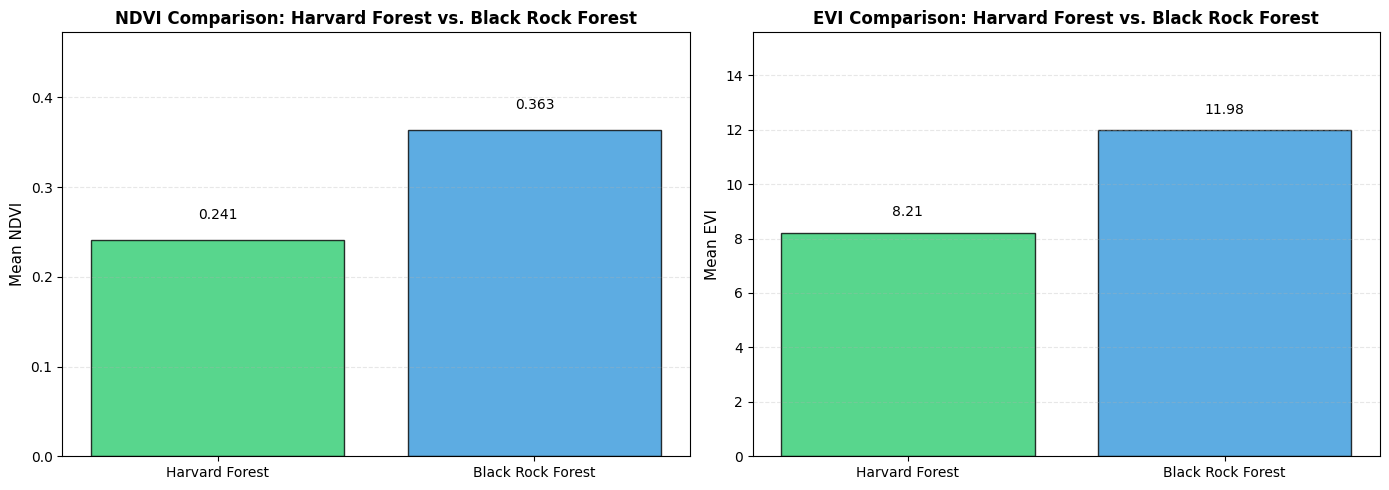


Comparison bar chart saved to Google Drive

------------------------------------------------------------
SITE COMPARISON SUMMARY
------------------------------------------------------------

Harvard Forest (Image Date: 2013-05-02, Cloud: 0.1%)
   NDVI: 0.2413
   EVI:  8.2138

Black Rock Forest (Image Date: 2013-08-20, Cloud: 4.1%)
   NDVI: 0.3635
   EVI:  11.9811

Differences (Black Rock - Harvard):
   NDVI: +0.1222 (+50.6%)
   EVI:  +3.7673 (+45.9%)

Black Rock Forest shows higher NDVI (+50.6%), suggesting denser/greener canopy
------------------------------------------------------------

Summary statistics saved to Google Drive


In [6]:
# SECTION 3: VISUALIZE & COMPARE NDVI/EVI BETWEEN SITES
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create Comparison Bar Charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# NDVI Comparison
sites = comparison_data['Site'].values
ndvi_values = comparison_data['NDVI_Mean'].values
colors = ['#2ecc71', '#3498db']

axes[0].bar(sites, ndvi_values, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_ylabel('Mean NDVI', fontsize=11)
axes[0].set_title('NDVI Comparison: Harvard Forest vs. Black Rock Forest', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', linestyle='--', alpha=0.3)
axes[0].set_ylim(0, max(ndvi_values) * 1.3)

# Add value labels on bars
for i, v in enumerate(ndvi_values):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# EVI Comparison
evi_values = comparison_data['EVI_Mean'].values

axes[1].bar(sites, evi_values, color=colors, edgecolor='black', alpha=0.8)
axes[1].set_ylabel('Mean EVI', fontsize=11)
axes[1].set_title('EVI Comparison: Harvard Forest vs. Black Rock Forest', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', linestyle='--', alpha=0.3)
axes[1].set_ylim(0, max(evi_values) * 1.3)

# Add value labels on bars
for i, v in enumerate(evi_values):
    axes[1].text(i, v + 0.5, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/NEON Hyperspectral ML Project/site_comparison_barchart.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison bar chart saved to Google Drive")

# Calculate & Display Differences
harvard = comparison_data[comparison_data['Site'] == 'Harvard Forest'].iloc[0]
black_rock = comparison_data[comparison_data['Site'] == 'Black Rock Forest'].iloc[0]

ndvi_diff = black_rock['NDVI_Mean'] - harvard['NDVI_Mean']
evi_diff = black_rock['EVI_Mean'] - harvard['EVI_Mean']

ndvi_pct = (ndvi_diff / harvard['NDVI_Mean']) * 100
evi_pct = (evi_diff / harvard['EVI_Mean']) * 100

print("\n" + "-"*60)
print("SITE COMPARISON SUMMARY")
print("-"*60)
print(f"\nHarvard Forest (Image Date: {harvard['Date']}, Cloud: {harvard['Cloud_Cover']:.1f}%)")
print(f"   NDVI: {harvard['NDVI_Mean']:.4f}")
print(f"   EVI:  {harvard['EVI_Mean']:.4f}")

print(f"\nBlack Rock Forest (Image Date: {black_rock['Date']}, Cloud: {black_rock['Cloud_Cover']:.1f}%)")
print(f"   NDVI: {black_rock['NDVI_Mean']:.4f}")
print(f"   EVI:  {black_rock['EVI_Mean']:.4f}")

print(f"\nDifferences (Black Rock - Harvard):")
print(f"   NDVI: {ndvi_diff:+.4f} ({ndvi_pct:+.1f}%)")
print(f"   EVI:  {evi_diff:+.4f} ({evi_pct:+.1f}%)")

if ndvi_diff > 0:
    print(f"\nBlack Rock Forest shows higher NDVI (+{ndvi_pct:.1f}%), suggesting denser/greener canopy")
else:
    print(f"\nHarvard Forest shows higher NDVI ({abs(ndvi_pct):.1f}% higher), suggesting denser/greener canopy")

print("-"*60)

# Save Summary Statistics
summary_stats = {
    'Harvard_NDVI': harvard['NDVI_Mean'],
    'Harvard_EVI': harvard['EVI_Mean'],
    'BlackRock_NDVI': black_rock['NDVI_Mean'],
    'BlackRock_EVI': black_rock['EVI_Mean'],
    'NDVI_Difference': ndvi_diff,
    'NDVI_PercentDiff': ndvi_pct,
    'EVI_Difference': evi_diff,
    'EVI_PercentDiff': evi_pct
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv('/content/drive/MyDrive/NEON Hyperspectral ML Project/site_comparison_summary_stats.csv', index=False)
print("\nSummary statistics saved to Google Drive")